In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class LogDensity(ABC):
    """
    Abstract class for probability densities where we know log density and its score. 
    """
    @property
    @abstractmethod
    def log_density(self, x : torch.Tensor) -> torch.Tensor:
        """
        Computes log(p(x))
        Args:
            x (torch.Tensor): some point of shape [batch_size, dim]

        Returns:
            torch.Tensor: log(p(x)) [batch_size, 1]
        """
        
        pass

    def score(self, x : torch.Tensor) -> torch.Tensor:
        """
        Returns the Gradient log density(x) i.e. the score
        Args:
            x: [batch_size, dim]
        Returns:
            score: [batch_size, dim]
        """
        x = x.unsqueeze(1)  # [batch_size, 1, dim]
        score = torch.vmap(torch.func.jacrev(self.log_density))(x)  # [batch_size, 1, dim, dim]
        return score.squeeze((1, 2, 3))  # [batch_size, dim]


class SampleDensity(ABC):
    """
    Abstract class for probability densities we can sample from.
    """
    
    @abstractmethod
    def sample(self, n : int) -> torch.Tensor:
        """
        Gives n sample of density. 

        Args:
            n (int): amount of datapoints to sample

        Returns:
            torch.Tensor: output samples [batch_size, dim]
        """
        pass

class Gaussian(torch.nn.Module, SampleDensity, LogDensity):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))
        
    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)

class GaussianMixture(torch.nn.Module, SampleDensity, LogDensity):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale + x_offset * torch.Tensor([1.0, 0.0])
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale + torch.Tensor([1.0, 0.0]) * x_offset
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

In [3]:
class ODE(ABC):
    """
    Abstract class for basic time dependent first order Ordinary differential equations given by 
    dx/dt = f(x,t) where f is some vector field, this can be written as dx_t = f(x_t, t) dt. We assume that f is given on [0,T]
    """
    @abstractmethod
    def drift_coefficient(self, x_t : torch.Tensor,t : torch.Tensor) -> torch.Tensor:
        """
        Returns f(x_t,t) 
        Args:
            x_t (torch.Tensor): input at time t [batch_size, dim]
            t (torch.Tensor): time t

        Returns:
            torch.Tensor: gives drift term of ODE [batch_size, dim]
        """
        pass

class SDE(ODE):
    """
    Abstract class for basic time dependent SDE of the form dx_t = f(x_t, t)dt + g(x_t, t) dB_t where (B_t) is some Brownian Motion. 
    We assume that f and g are given on [0,T].
    """
    @abstractmethod
    def diffusion_coefficient(self, x_t : torch.Tensor,t : torch.Tensor) -> torch.Tensor:
        """
        Returns g(x_t,t)
        Args:
            x_t (torch.Tensor): input at time t [batch_size, dim]
            t (torch.Tensor): time t

        Returns:
            torch.Tensor: gives difussion part of SDE [batch_size, dim]
        """
        pass




In [4]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (bs,1)
            - dt: time, shape (bs,1)
        Returns:
            - nxt: state at time t + dt (bs, dim)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (bs, num_timesteps,1)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (bs, num_timesteps, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num
            _timesteps, dim)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.ode.drift_coefficient(xt,t) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.sde.drift_coefficient(xt,t) * h + self.sde.diffusion_coefficient(xt,t) * torch.sqrt(h) * torch.randn_like(xt)

In [5]:
class ConditionalProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: SampleDensity, p_data: SampleDensity):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, dim)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, dim)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, dim)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """ 
        pass

In [6]:

class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(self(torch.zeros(1,1)), torch.zeros(1,1))
        # Check alpha_1 = 1
        assert torch.allclose(self(torch.ones(1,1)), torch.ones(1,1))
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            t: time (num_samples, 1)
        Returns:
            alpha_t (num_samples, 1)
        """ 
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            t: time (num_samples, 1)
        Returns:
            d/dt alpha_t (num_samples, 1)
        """ 
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = torch.vmap(torch.functional.jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)
    
class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(self(torch.zeros(1,1)), torch.ones(1,1))
        # Check beta_1 = 0
        assert torch.allclose(self(torch.ones(1,1)), torch.zeros(1,1))
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        pass 

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt beta_t (num_samples, 1)
        """ 
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = torch.vmap(torch.functional.jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)
    
class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """ 
        return t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        return torch.ones_like(t)

class SquareRootBeta(Beta):
    """
    Implements beta_t = rt(1-t)
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        return torch.sqrt(1-t)

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        return - 0.5 / (torch.sqrt(1 - t) + 1e-4)

In [7]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    """
    Gaussian Path following N(alpha_t * z, beta_t**2 * I_d)
    """
    def __init__(self, p_data: SampleDensity, alpha: Alpha, beta: Beta, device = 'cpu'):
        p_simple = Gaussian.isotropic(p_data.dim, 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta
        self.device = device
        
    def sample_conditioning_variable(self, n: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - n: the number of samples
        Returns:
            - z: samples from p(z), (n, dim)
        """
        return self.p_data.sample(n)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable [n, dim]
            - t: time (n, 1)
        Returns:
            - x: samples from p_t(x|z), (n, dim)
        """
        
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z, device=self.device)        
                
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (n, dim)
            - z: conditioning variable (n, dim)
            - t: time (n, 1)
        Returns:
            - conditional_vector_field: conditional vector field (n, dim)
        """ 
        return (self.alpha.dt(t) - self.beta.dt(t)/self.beta(t) * self.alpha(t)) * z + (self.beta.dt(t)/self.beta(t)) * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (n, dim)
            - z: conditioning variable (n, dim)
            - t: time (n, 1)
        Returns:
            - conditional_score: conditional score (n, dim)
        """ 
        return (self.alpha(t) *z - x)/self.beta(t)**2

In [8]:
def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        return self.net(xt)        

In [9]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

        # Finish
        self.model.eval()

In [10]:
class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z = self.path.p_data.sample(batch_size) # (bs, dim)
        t = torch.rand(batch_size,1).to(z) # (bs, 1)
        x = self.path.sample_conditional_path(z,t) # (bs, dim)

        ut_theta = self.model(x,t) # (bs, dim)
        ut_ref = self.path.conditional_score(x,z,t) # (bs, dim)
        error = torch.sum(torch.square(ut_theta - ut_ref), dim=-1) # (bs,)
        return torch.mean(error)

In [11]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=1.0, scale=10).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[100,100,100,100,100])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000)

Epoch 4999, loss: 18.52040672302246: : 5000it [01:12, 69.20it/s] 


In [12]:
class Langevin_Schedule(SDE):
    def __init__(self, score_model : MLPVectorField, schedule : Beta):
        super().__init__()
        self.score = score_model
        self.reverse_schedule = schedule

    def drift_coefficient(self, x_t : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        
        score = self.score(x_t,t)
        schedule = self.reverse_schedule(t)
        
        return schedule ** 2/2 * score
    
    def diffusion_coefficient(self, x_t : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        
        return self.reverse_schedule(t) * torch.randn_like(x_t)

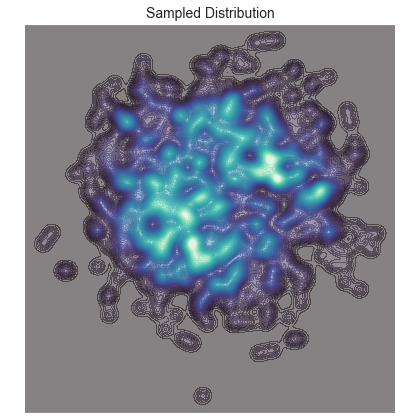

In [13]:
ode = Langevin_Schedule(flow_model, SquareRootBeta())

model_sampler = EulerMaruyamaSimulator(ode)

steps= torch.linspace(0.0, 1, 1000).view(1,-1,1).expand(1000,-1,1).to(device) 

def plot_samples(samples: torch.Tensor, 
                 title: str = "Sampled Distribution", 
                 figsize: tuple = (6, 6), 
                 point_alpha: float = 0.3, 
                 point_size: int = 8, 
                 kde: bool = True,
                 contour: bool = True,
                 cmap: str = "mako",
                 save_path: str = None):
    """
    Visualize 2D distribution samples with optional KDE and contours.

    Args:
        samples (torch.Tensor): Tensor of shape (N, 2)
        title (str): Plot title
        figsize (tuple): Size of the figure
        point_alpha (float): Transparency for scatter points
        point_size (int): Size of scatter points
        kde (bool): Whether to plot kernel density estimate
        contour (bool): Whether to overlay contour lines
        cmap (str): Colormap for KDE
        save_path (str, optional): Path to save the plot
    """
    samples_np = samples.detach().cpu().numpy()
    x, y = samples_np[:, 0], samples_np[:, 1]

    plt.figure(figsize=figsize)
    plt.style.use("dark_background")
    sns.set_theme(style="dark", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    if kde:
        sns.kdeplot(
            x=x, y=y,
            fill=True,
            cmap=cmap,
            bw_adjust=0.3,
            levels=100,
            thresh=0.00,
            alpha=0.5,
        )

    if contour:
        sns.kdeplot(
            x=x, y=y,
            cmap="gray",
            bw_adjust=0.5,
            levels=10,
            linewidths=1
        )

    #plt.scatter(x, y, color='black', s=point_size, alpha=point_alpha, edgecolors='none')
    plt.title(title, fontsize=14)
    plt.axis("equal")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

plot_samples(model_sampler.simulate(path.p_simple.sample(1000), steps), contour=False)